In [1]:
from qubic.lib.MapMaking.FrequencyMapMaking import PipelineFrequencyMapMaking
import yaml
import numpy as np
import pickle
import healpy as hp
import matplotlib.pyplot as plt
from pyoperators import MPI

from pyoperators import DiagonalOperator, BlockDiagonalOperator
from pysimulators import ProjectionOperator

comm = MPI.COMM_WORLD


[proton:797675] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


In [2]:
parameters_path = '/home/lkardum/micromamba/envs/venv-localzadnji/lib/python3.10/site-packages/qubic/scripts/MapMaking/src/FMM/params.yml'
with open(parameters_path, 'r') as tf:
    params = yaml.safe_load(tf)

In [3]:
params['PCG']['n_iter_pcg'] = 100

In [4]:
pip = PipelineFrequencyMapMaking(comm = comm, file = '/home/lkardum/moje-tekice/fmm-out.pkl', parameters_dict= params)

executing: self.detarray = '/home/lkardum/micromamba/envs/venv-localzadnji/lib/python3.10/site-packages/qubic/calfiles/CalQubic_DetArray_v4_FI.fits'
executing: self.hornarray = '/home/lkardum/micromamba/envs/venv-localzadnji/lib/python3.10/site-packages/qubic/calfiles/CalQubic_HornArray_FI.fits'
executing: self.optics = '/home/lkardum/micromamba/envs/venv-localzadnji/lib/python3.10/site-packages/qubic/calfiles/CalQubic_Optics_v3_FI_150.txt'
executing: self.primbeam = '/home/lkardum/micromamba/envs/venv-localzadnji/lib/python3.10/site-packages/qubic/calfiles/CalQubic_PrimBeam_v2.fits'
executing: self.synthbeam = '/home/lkardum/micromamba/envs/venv-localzadnji/lib/python3.10/site-packages/qubic/calfiles/CalQubic_Synthbeam_Analytical_220_FI.fits'
executing: self.detarray = '/home/lkardum/micromamba/envs/venv-localzadnji/lib/python3.10/site-packages/qubic/calfiles/CalQubic_DetArray_v4_FI.fits'
executing: self.hornarray = '/home/lkardum/micromamba/envs/venv-localzadnji/lib/python3.10/site-p

In [5]:
params['QUBIC']['nrec']

2

In [6]:
stacked_dptdp_inv = np.ones((len(pip.H_out.operands[1].operands),12*pip.params['SKY']['nside']**2))

In [7]:
proj_op = pip.H_out.operands[1].operands[0].operands[0].operands[-1]

In [8]:
proj_op.T(np.ones((992,1000,3))).shape

(196608, 3)

In [9]:
pip.H_out.operands[1].operands[0].operands[0].operands[-1].matrix.data.index.shape

(992000, 9)

In [10]:
pip_planck_precond.joint.pl143.get_invntt_operator().data[:,0]

NameError: name 'pip_planck_precond' is not defined

In [11]:
def proxy_preconditioner_fast(self, FI = True):
    H = self.H_out
    
    # ode len H.operands[1].operands triba odgovarat nrec 
    stacked_dptdp_inv = np.zeros((len(H.operands[1].operands),12*self.params['SKY']['nside']**2))
    for reco_map in range(len(H.operands[1].operands)):
        
        if self.params['PLANCK']['external_data'] == False:
            H_nrec = H.operands[1].operands[reco_map]
        else:
            H_nrec = H.operands[1].operands[reco_map].operands[0].operands[0].operands[1]
        
        dptdp_nrec = np.zeros((12*self.params['SKY']['nside']**2))
        # ima nrec reco_map i nsub_out i:
        for i in range(len(H_nrec.operands)):
            
            # H_single je operator na jednon frekvenciji nsub_out
            H_single = H_nrec.operands[i]
            D = None
            #D = H_single.operands[1]
            for op in H_single.operands:
                if isinstance(op, DiagonalOperator):
                    D = op
                    break
            P = None
            for op in H_single.operands:
                if isinstance(op, ProjectionOperator):
                    P = op
                    break
            #P = H_single.operands[-1]
            sh = P.matrix.data.index.shape
            if FI:
                no_det = 992
            else:
                no_det = 256
            point_per_det = int(sh[0] / no_det)
            mapPtP_perdet_seq = np.zeros((no_det, 12 * self.params['SKY']['nside']**2))
            sample_ranges = [(det * point_per_det, (det + 1) * point_per_det) for det in range(no_det)]
            for det, (start, end) in enumerate(sample_ranges):
                indices = P.matrix.data.index[start:end, :]  
                weights = P.matrix.data.r11[start:end, :]
                flat_indices = indices.ravel()
                flat_weights = weights.ravel()

                mapPitPi = np.zeros(12 * self.params['SKY']['nside']**2)
                np.add.at(mapPitPi, flat_indices, flat_weights**2)

                mapPtP_perdet_seq[det, :] = mapPitPi
            D_elements = D.data
            D_sq = D_elements**2
            mapPtP_seq_scaled = D_sq[:, np.newaxis] * mapPtP_perdet_seq 
            dptdp = mapPtP_seq_scaled.sum(axis = 0)
            dptdp_nrec += dptdp
        
        if self.params['PLANCK']['external_data'] == True:
            Diag_planck_143 = self.joint.pl143.get_invntt_operator().data[:,0]
            Diag_planck_217 = self.joint.pl217.get_invntt_operator().data[:,0]
            dptdp_nrec = dptdp_nrec + Diag_planck_143**2 + Diag_planck_217**2
           
        dptdp_nrec_inv = 1 / dptdp_nrec
        dptdp_nrec_inv[np.isinf(dptdp_nrec_inv)] = 0.
        stacked_dptdp_inv[reco_map] = dptdp_nrec_inv
    if self.params['PLANCK']['external_data'] == False:
        preconditioner = BlockDiagonalOperator( \
                [DiagonalOperator(ci, broadcast='rightward') for ci in stacked_dptdp_inv],
                new_axisin=0)
    else:
        preconditioner = BlockDiagonalOperator( \
                [DiagonalOperator(ci[self.seenpix], broadcast='rightward') for ci in stacked_dptdp_inv],
                new_axisin=0)
    return preconditioner

In [12]:
#proxy_preconditioner_fast(pip)

In [8]:
pip.run()


=========== Map-Making ===========

 Iter     Tol      time
   1: 6.7260e-01 0.51484 [64.32913541  1.57833033  1.76305197 68.94410343  2.22898874  2.55400751]
   2: 4.3793e-01 0.51229 [52.79519789  3.10402222  3.49891694 56.44458083  4.01304867  4.55127893]
   3: 2.4516e-01 0.52619 [45.34555946  4.10372447  4.54940605 49.01428386  4.96132859  5.41589043]
   4: 1.3547e-01 0.50857 [39.50604832  4.67609918  5.03872667 42.98466589  5.31094847  5.6289375 ]
   5: 8.9852e-02 0.55242 [35.24338514  4.82193006  5.0209855  38.92893271  5.4091641   5.48072452]
   6: 8.6759e-02 0.58726 [33.16483024  4.76976207  4.85619353 36.99330418  5.31447697  5.306054  ]
   7: 5.7492e-02 0.56773 [30.80224142  4.77237269  4.73568531 34.74810418  5.23131721  5.17890924]
   8: 4.3727e-02 0.59766 [28.62236077  4.84956526  4.67444864 32.35682327  5.25402642  5.14369028]
   9: 4.8682e-02 0.64520 [27.21730439  4.88639452  4.60528345 30.44684834  5.25293043  5.09458905]
  10: 3.6340e-02 0.64109 [26.48338678  4.9116643

In [70]:
with open('/home/lkardum/moje-tekice/fmm-out.pkl', 'rb') as f:
    x = pickle.load(f)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, '$N_{iter}$')

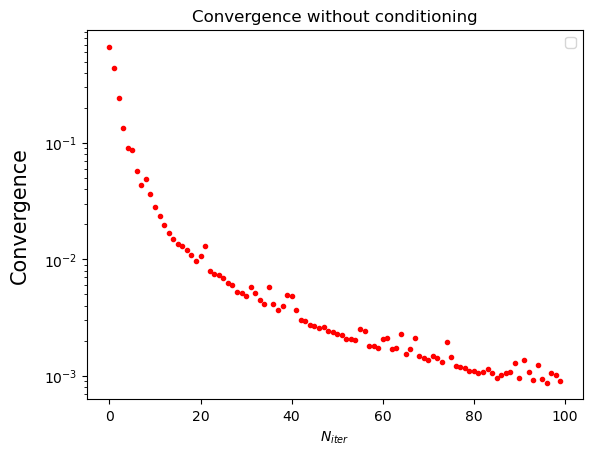

In [71]:
plt.figure()
plt.plot(range(len(x['convergence'])), x['convergence'], '.', color = 'red')
plt.legend()
plt.title(r"Convergence without conditioning")
plt.ylabel(r'Convergence', fontsize=15, labelpad=10)
plt.yscale('log')
plt.xlabel(r'$N_{iter}$')

In [5]:
params_precond = params.copy()

In [6]:
params_precond['PCG']['preconditioner'] = True
#params_precond['PCG']['n_iter_pcg'] = 100

In [7]:
pip_precond = PipelineFrequencyMapMaking(comm = comm, file = '/home/lkardum/moje-tekice/fmm-out_precond.pkl', parameters_dict= params_precond)

executing: self.detarray = '/home/lkardum/micromamba/envs/venv-localzadnji/lib/python3.10/site-packages/qubic/calfiles/CalQubic_DetArray_v4_FI.fits'
executing: self.hornarray = '/home/lkardum/micromamba/envs/venv-localzadnji/lib/python3.10/site-packages/qubic/calfiles/CalQubic_HornArray_FI.fits'
executing: self.optics = '/home/lkardum/micromamba/envs/venv-localzadnji/lib/python3.10/site-packages/qubic/calfiles/CalQubic_Optics_v3_FI_150.txt'
executing: self.primbeam = '/home/lkardum/micromamba/envs/venv-localzadnji/lib/python3.10/site-packages/qubic/calfiles/CalQubic_PrimBeam_v2.fits'
executing: self.synthbeam = '/home/lkardum/micromamba/envs/venv-localzadnji/lib/python3.10/site-packages/qubic/calfiles/CalQubic_Synthbeam_Analytical_220_FI.fits'
executing: self.detarray = '/home/lkardum/micromamba/envs/venv-localzadnji/lib/python3.10/site-packages/qubic/calfiles/CalQubic_DetArray_v4_FI.fits'
executing: self.hornarray = '/home/lkardum/micromamba/envs/venv-localzadnji/lib/python3.10/site-p

In [18]:
pip_precond.run()


=========== Map-Making ===========

 Iter     Tol      time
   1: 6.0526e-01 0.58713 [70.35034799  1.12722072  1.1813694  68.08797232  3.74832418  4.18941794]
   2: 3.7806e-01 0.52458 [58.27749961  3.13620802  3.401167   50.61092449  7.73542984  7.51460802]
   3: 3.0446e-01 0.51957 [51.89046806  4.11652878  4.45441599 40.90918541  8.69388258  8.54376004]
   4: 2.4219e-01 0.51937 [43.53555734  5.01581004  5.32342935 34.5418498   9.08475175  8.84483814]
   5: 1.6869e-01 0.52470 [36.20980908  6.09737399  6.29879462 33.01833482  8.93553041  8.78365793]
   6: 1.2669e-01 0.51652 [33.12974665  6.61753039  6.69443114 32.77895247  8.24738292  8.02122676]
   7: 8.1689e-02 0.51997 [30.71563409  7.0475355   6.96995537 31.08654871  7.08223273  6.85073767]
   8: 7.3470e-02 0.51769 [29.61250264  7.06146446  6.94368837 29.77749917  5.87668736  5.65496793]
   9: 5.8520e-02 0.51952 [29.07102525  6.93129889  6.82352087 28.7066906   5.0343639   4.90973924]
  10: 3.8190e-02 0.53405 [28.58615722  6.5764591

In [15]:
pip.H_out

CompositionOperator([
    ReshapeOperator((2,992,1000), 1984000, None),
    BlockDiagonalOperator([
        AdditionOperator([
            CompositionOperator([
                ConvolutionTruncatedExponentialOperator(0.01, None, shapein=(992,1000), shapeout=(992,1000)),
                DiagonalOperator(array([0.00032027649516002885, ..., 0.00032027649516002885], dtype=float64), broadcast='rightward', None),
                ReshapeOperator((992,1000,1), (992,1000), None),
                DenseBlockDiagonalOperator(array([[[[1.478034013509218e-20, ..., 1.8100696236749797e-36]]]], dtype=float64), naxesin=1, naxesout=1, None, shapein=(992,1000,3), shapeout=(992,1000,1)),
                ProjectionOperator(None, None, shapein=(196608,3), shapeout=(992,1000,3))]),
            CompositionOperator([
                ConvolutionTruncatedExponentialOperator(0.01, None, shapein=(992,1000), shapeout=(992,1000)),
                DiagonalOperator(array([0.0003071469504282296, ..., 0.00030714695042822

In [16]:
pip.H_out.T(pip.H_out)
pip.H_out

CompositionOperator([
    ReshapeOperator((2,992,1000), 1984000, None),
    BlockDiagonalOperator([
        AdditionOperator([
            CompositionOperator([
                ConvolutionTruncatedExponentialOperator(0.01, None, shapein=(992,1000), shapeout=(992,1000)),
                DiagonalOperator(array([0.00032027649516002885, ..., 0.00032027649516002885], dtype=float64), broadcast='rightward', None),
                ReshapeOperator((992,1000,1), (992,1000), None),
                DenseBlockDiagonalOperator(array([[[[1.478034013509218e-20, ..., 1.8100696236749797e-36]]]], dtype=float64), naxesin=1, naxesout=1, None, shapein=(992,1000,3), shapeout=(992,1000,1)),
                ProjectionOperator(None, None, shapein=(196608,3), shapeout=(992,1000,3))]),
            CompositionOperator([
                ConvolutionTruncatedExponentialOperator(0.01, None, shapein=(992,1000), shapeout=(992,1000)),
                DiagonalOperator(array([0.0003071469504282296, ..., 0.00030714695042822

In [24]:
pip.H_out.T(pip.H_out).shapein

(2, 196608, 3)

In [ ]:
# this is the matrix M
M_precond = pip_precond.proxy_preconditioner_fast()
M_precond

BlockDiagonalOperator([
    DiagonalOperator(array([0.0, ..., 5532.571652382267], dtype=float64), broadcast='rightward', None),
    DiagonalOperator(array([0.0, ..., 41630.86444837822], dtype=float64), broadcast='rightward', None)])

In [57]:
with open('/home/lkardum/moje-tekice/fmm-out_precond.pkl', 'rb') as f:
    y = pickle.load(f)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, '$N_{iter}$')

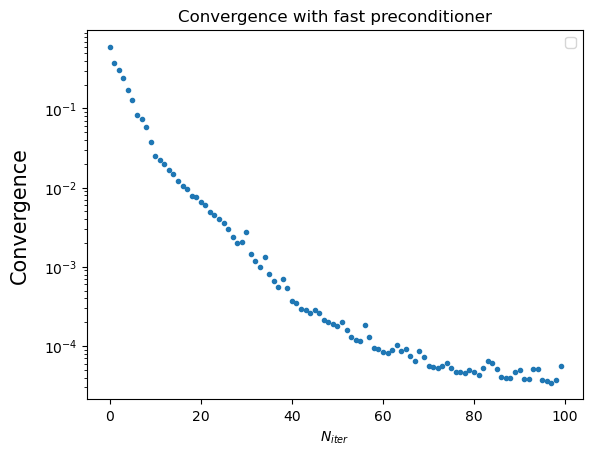

In [58]:
plt.figure()
plt.plot(range(len(y['convergence'])), y['convergence'], '.')
plt.legend()
plt.title(r"Convergence with fast preconditioner")
plt.ylabel(r'Convergence', fontsize=15, labelpad=10)
plt.yscale('log')
plt.xlabel(r'$N_{iter}$')

Text(0.5, 0, '$N_{iter}$')

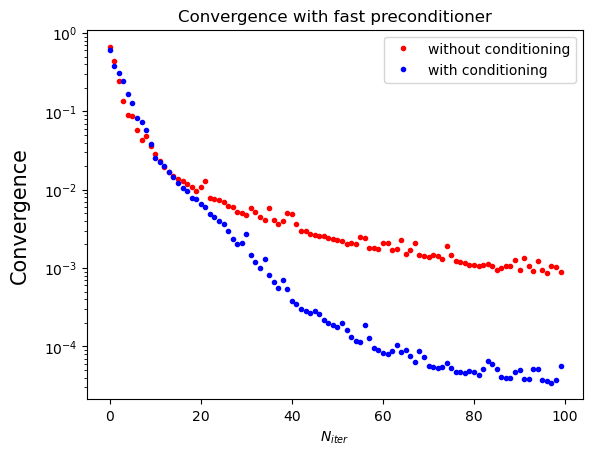

In [76]:
plt.figure()
plt.plot(range(len(x['convergence'])), x['convergence'], '.', label = 'without conditioning', color = 'red')
plt.plot(range(len(y['convergence'])), y['convergence'], '.', label = 'with conditioning', color = 'blue')
plt.legend()
plt.title(r"Convergence with fast preconditioner")
plt.ylabel(r'Convergence', fontsize=15, labelpad=10)
plt.yscale('log')
plt.xlabel(r'$N_{iter}$')

Added Planck data:

In [77]:
pip.H_out

CompositionOperator([
    ReshapeOperator((2,992,1000), 1984000, None),
    BlockDiagonalOperator([
        AdditionOperator([
            CompositionOperator([
                ConvolutionTruncatedExponentialOperator(0.01, None, shapein=(992,1000), shapeout=(992,1000)),
                DiagonalOperator(array([0.00032027649516002885, ..., 0.00032027649516002885], dtype=float64), broadcast='rightward', None),
                ReshapeOperator((992,1000,1), (992,1000), None),
                DenseBlockDiagonalOperator(array([[[[1.478034013509218e-20, ..., 1.8100696236749797e-36]]]], dtype=float64), naxesin=1, naxesout=1, None, shapein=(992,1000,3), shapeout=(992,1000,1)),
                ProjectionOperator(None, None, shapein=(196608,3), shapeout=(992,1000,3))]),
            CompositionOperator([
                ConvolutionTruncatedExponentialOperator(0.01, None, shapein=(992,1000), shapeout=(992,1000)),
                DiagonalOperator(array([0.0003071469504282296, ..., 0.00030714695042822

In [8]:
params_planck = params.copy()
params_planck['PLANCK']['external_data'] = True
params_planck['PCG']['preconditioner'] = False
params_planck['PCG']['tol_pcg'] = 1e-15

In [9]:
pip_planck = PipelineFrequencyMapMaking(comm = comm, file = '/home/lkardum/moje-tekice/fmm-out_planck.pkl', parameters_dict= params_planck)

executing: self.detarray = '/home/lkardum/micromamba/envs/venv-localzadnji/lib/python3.10/site-packages/qubic/calfiles/CalQubic_DetArray_v4_FI.fits'
executing: self.hornarray = '/home/lkardum/micromamba/envs/venv-localzadnji/lib/python3.10/site-packages/qubic/calfiles/CalQubic_HornArray_FI.fits'
executing: self.optics = '/home/lkardum/micromamba/envs/venv-localzadnji/lib/python3.10/site-packages/qubic/calfiles/CalQubic_Optics_v3_FI_150.txt'
executing: self.primbeam = '/home/lkardum/micromamba/envs/venv-localzadnji/lib/python3.10/site-packages/qubic/calfiles/CalQubic_PrimBeam_v2.fits'
executing: self.synthbeam = '/home/lkardum/micromamba/envs/venv-localzadnji/lib/python3.10/site-packages/qubic/calfiles/CalQubic_Synthbeam_Analytical_220_FI.fits'
executing: self.detarray = '/home/lkardum/micromamba/envs/venv-localzadnji/lib/python3.10/site-packages/qubic/calfiles/CalQubic_DetArray_v4_FI.fits'
executing: self.hornarray = '/home/lkardum/micromamba/envs/venv-localzadnji/lib/python3.10/site-p

In [37]:
#pip_planck.H_out

In [ ]:
# operator for each nrec can be found as:
#add_operator_nrec = pip_planck_precond.H_out.operands[1].operands[nrec].operands[0].operands[0].operands[1]

In [38]:
pip_planck.run()


=========== Map-Making ===========



 Iter     Tol      time
   1: 5.7439e-01 1.40073 [25.50290388  1.57240467  1.74711367 46.51094652  2.27029693  2.59380655]
   2: 2.4788e-01 1.18555 [17.25608884  1.68656672  1.84927029 29.00777773  2.63336023  2.89175724]
   3: 1.4148e-01 1.15443 [14.77043645  1.37457879  1.47242645 18.21902851  2.53499773  2.67060588]
   4: 6.6946e-02 1.35182 [13.46679285  1.08472463  1.1373758  12.02814135  2.27001618  2.36575641]
   5: 3.7341e-02 1.23692 [12.32616543  0.95168158  1.00228843  9.74576019  1.96472258  2.03459887]
   6: 2.0920e-02 1.12290 [11.86930769  0.93884346  0.98522866  9.06967903  1.73344991  1.79355814]
   7: 1.0513e-02 1.14610 [11.75252594  0.96870745  1.01530543  8.80771325  1.57420909  1.65146166]
   8: 4.7927e-03 1.22031 [11.7309715   1.00777508  1.05462426  8.70679536  1.48595366  1.58246994]
   9: 2.6471e-03 1.10927 [11.73108712  1.04111727  1.08961472  8.67582146  1.45433115  1.56753909]
  10: 1.8173e-03 1.17808 [11.74612337  1.07470919  1.12491979  8.67233358  1.46566351

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, '$N_{iter}$')

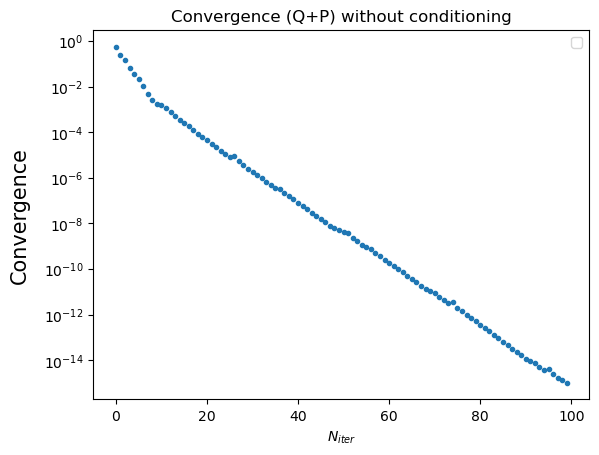

In [16]:
with open('/home/lkardum/moje-tekice/fmm-out_planck.pkl', 'rb') as f:
    x_planck = pickle.load(f)
plt.figure()
plt.plot(range(len(x_planck['convergence'])), x_planck['convergence'], '.')
plt.legend()
plt.title(r"Convergence (Q+P) without conditioning")
plt.ylabel(r'Convergence', fontsize=15, labelpad=10)
plt.yscale('log')
plt.xlabel(r'$N_{iter}$')

In [10]:
params_planck_precond = params_planck.copy()
params_planck_precond['PCG']['preconditioner'] = True
params_planck_precond['PCG']['tol_pcg'] = 1e-15

In [11]:
pip_planck_precond = PipelineFrequencyMapMaking(comm = comm, file = '/home/lkardum/moje-tekice/fmm-out_planck_precond.pkl', parameters_dict= params_planck_precond)

executing: self.detarray = '/home/lkardum/micromamba/envs/venv-localzadnji/lib/python3.10/site-packages/qubic/calfiles/CalQubic_DetArray_v4_FI.fits'
executing: self.hornarray = '/home/lkardum/micromamba/envs/venv-localzadnji/lib/python3.10/site-packages/qubic/calfiles/CalQubic_HornArray_FI.fits'
executing: self.optics = '/home/lkardum/micromamba/envs/venv-localzadnji/lib/python3.10/site-packages/qubic/calfiles/CalQubic_Optics_v3_FI_150.txt'
executing: self.primbeam = '/home/lkardum/micromamba/envs/venv-localzadnji/lib/python3.10/site-packages/qubic/calfiles/CalQubic_PrimBeam_v2.fits'
executing: self.synthbeam = '/home/lkardum/micromamba/envs/venv-localzadnji/lib/python3.10/site-packages/qubic/calfiles/CalQubic_Synthbeam_Analytical_220_FI.fits'
executing: self.detarray = '/home/lkardum/micromamba/envs/venv-localzadnji/lib/python3.10/site-packages/qubic/calfiles/CalQubic_DetArray_v4_FI.fits'
executing: self.hornarray = '/home/lkardum/micromamba/envs/venv-localzadnji/lib/python3.10/site-p

In [30]:
#pip_planck_precond.H_out

In [31]:
#pip_planck_precond.H_out.T(pip_planck_precond.H_out).shapein

The H_out operator in case of Planck data is masked with seenpix:

In [14]:
# definition from Qfmm and Qacquisition:
# 
# #if self.params['PLANCK']['external_data']:
 #           self.H_out_all_pix = self.joint.get_operator(fwhm=self.fwhm_out)
  #          self.H_out = self.joint.get_operator(
   #             fwhm=self.fwhm_out, seenpix=self.seenpix
    #        )  
     #   else:
      #      self.H_out = self.joint.qubic.get_operator(fwhm=self.fwhm_out)

#def get_operator(self, fwhm=None, seenpix=None):
#
 #       if seenpix is not None:
  #          U = (
   #             ReshapeOperator((sum(seenpix) * 3), (sum(seenpix), 3))
    #            * PackOperator(
     #               np.broadcast_to(seenpix[:, None], (seenpix.size, 3)).copy()
      #          )
       #     ).T
        #else:
         #   U = IdentityOperator()

In [15]:
pip_planck_precond.seenpix

array([False, False, False, ..., False, False, False])

In [29]:
pip_planck_precond.run()


=========== Map-Making ===========

 Iter     Tol      time
   1: 5.9538e-01 1.37123 [28.98561954  1.375707    1.47224435 33.33752325  2.98003558  3.2252812 ]
   2: 2.6975e-01 1.58576 [20.23468217  1.63890008  1.78232645 16.75552473  3.19157636  3.38690675]
   3: 1.4831e-01 1.37589 [13.67702168  1.57696911  1.71787245 12.64768317  2.80566968  2.92073148]
   4: 5.5405e-02 1.42784 [12.01604408  1.44213287  1.56395935 10.31802592  2.28097159  2.41707731]
   5: 2.3251e-02 1.15000 [11.7908606   1.23563354  1.33651535  9.20472205  1.83411198  1.976879  ]
   6: 1.2993e-02 1.16438 [11.82656776  1.10581853  1.19614203  8.79554801  1.6475037   1.7758586 ]
   7: 7.2474e-03 1.48575 [11.80675961  1.03638955  1.1187578   8.66010083  1.57138532  1.68799584]
   8: 4.2084e-03 1.23647 [11.76528109  1.00036276  1.07394307  8.61973432  1.54809108  1.65514844]
   9: 2.7408e-03 1.24923 [11.75229346  1.01619235  1.08323848  8.6339294   1.59325978  1.69003685]
  10: 1.6167e-03 1.13922 [11.73392367  1.0604073

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, '$N_{iter}$')

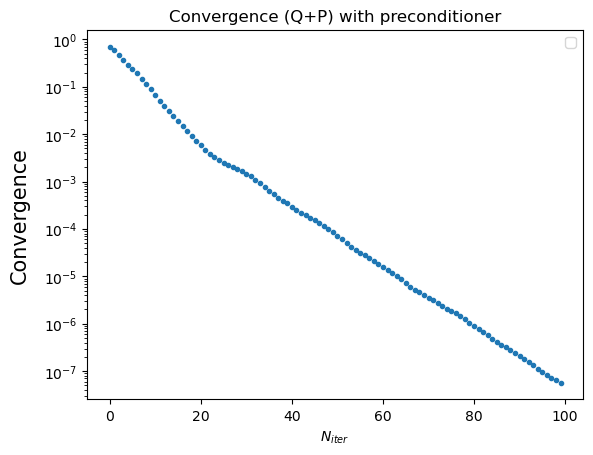

In [18]:
with open('/home/lkardum/moje-tekice/fmm-out_planck_precond.pkl', 'rb') as f:
    y_planck = pickle.load(f)
plt.figure()
plt.plot(range(len(y_planck['convergence'])), y_planck['convergence'], '.')
plt.legend()
plt.title(r"Convergence (Q+P) with preconditioner")
plt.ylabel(r'Convergence', fontsize=15, labelpad=10)
plt.yscale('log')
plt.xlabel(r'$N_{iter}$')

Text(0.5, 0, '$N_{iter}$')

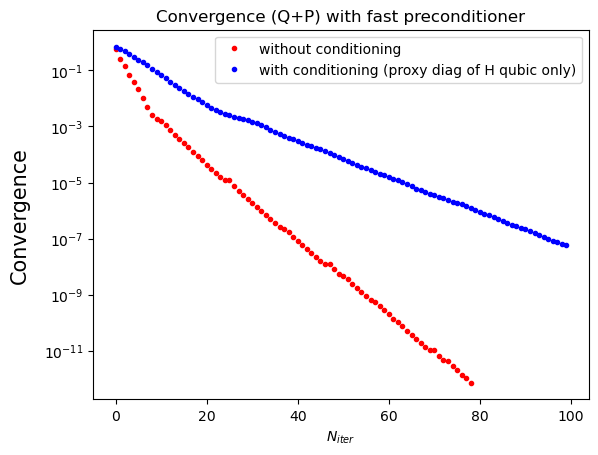

In [27]:
plt.figure()
plt.plot(range(len(x_planck['convergence'])), x_planck['convergence'], '.', label = 'without conditioning', color = 'red')
plt.plot(range(len(y_planck['convergence'])), y_planck['convergence'], '.', label = 'with conditioning (proxy diag of H qubic only)', color = 'blue')
plt.legend()
plt.title(r"Convergence (Q+P) with fast preconditioner")
plt.ylabel(r'Convergence', fontsize=15, labelpad=10)
plt.yscale('log')
plt.xlabel(r'$N_{iter}$')

In [33]:
invN_planck_143 = pip_planck_precond.joint.pl143.get_invntt_operator()

In [66]:
invN_planck_143.data[:,2]

array([0.7097958 , 0.69818294, 0.6876412 , ..., 0.70470226, 0.7047426 ,
       0.7209062 ], dtype=float32)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, '$N_{iter}$')

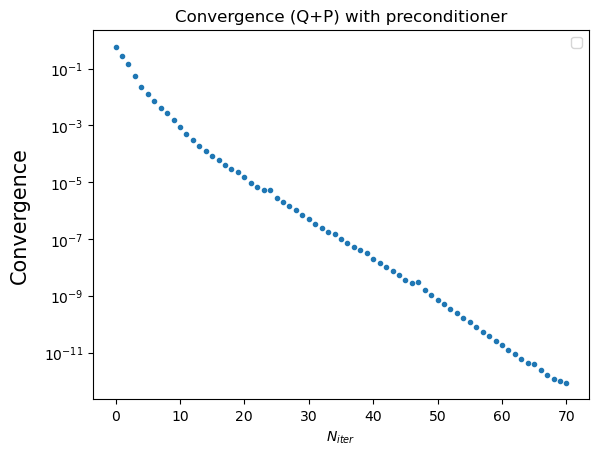

In [33]:
with open('/home/lkardum/moje-tekice/fmm-out_planck_precond.pkl', 'rb') as f:
    y_planck = pickle.load(f)
plt.figure()
plt.plot(range(len(y_planck_invN['convergence'])), y_planck_invN['convergence'], '.')
plt.legend()
plt.title(r"Convergence (Q+P) with preconditioner")
plt.ylabel(r'Convergence', fontsize=15, labelpad=10)
plt.yscale('log')
plt.xlabel(r'$N_{iter}$')

Text(0.5, 0, '$N_{iter}$')

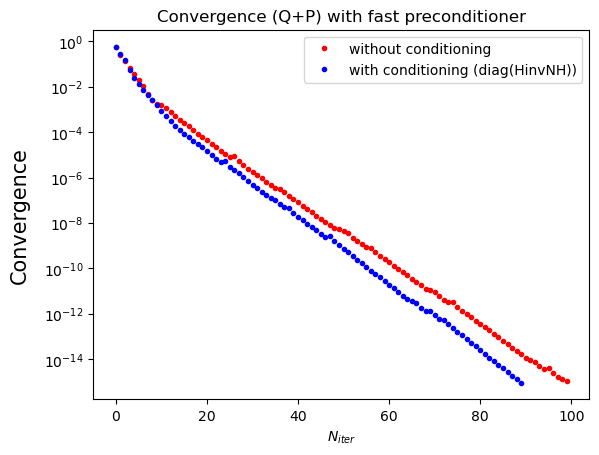

In [40]:
plt.figure()
plt.plot(range(len(x_planck['convergence'])), x_planck['convergence'], '.', label = 'without conditioning', color = 'red')
plt.plot(range(len(y_planck['convergence'])), y_planck['convergence'], '.', label = 'with conditioning (diag(HinvNH))', color = 'blue')
plt.legend()
plt.title(r"Convergence (Q+P) with fast preconditioner")
plt.ylabel(r'Convergence', fontsize=15, labelpad=10)
plt.yscale('log')
plt.xlabel(r'$N_{iter}$')

In [12]:
params_planck_precond_x0 = params_planck_precond.copy()
params_planck_precond_x0['PCG']['preconditioner'] = True
params_planck_precond_x0['PCG']['tol_pcg'] = 1e-15

In [13]:
pip_planck_precond_x0 = PipelineFrequencyMapMaking(comm = comm, file = '/home/lkardum/moje-tekice/fmm-out_planck_precond_x0.pkl', parameters_dict= params_planck_precond_x0)

executing: self.detarray = '/home/lkardum/micromamba/envs/venv-localzadnji/lib/python3.10/site-packages/qubic/calfiles/CalQubic_DetArray_v4_FI.fits'
executing: self.hornarray = '/home/lkardum/micromamba/envs/venv-localzadnji/lib/python3.10/site-packages/qubic/calfiles/CalQubic_HornArray_FI.fits'
executing: self.optics = '/home/lkardum/micromamba/envs/venv-localzadnji/lib/python3.10/site-packages/qubic/calfiles/CalQubic_Optics_v3_FI_150.txt'
executing: self.primbeam = '/home/lkardum/micromamba/envs/venv-localzadnji/lib/python3.10/site-packages/qubic/calfiles/CalQubic_PrimBeam_v2.fits'
executing: self.synthbeam = '/home/lkardum/micromamba/envs/venv-localzadnji/lib/python3.10/site-packages/qubic/calfiles/CalQubic_Synthbeam_Analytical_220_FI.fits'
executing: self.detarray = '/home/lkardum/micromamba/envs/venv-localzadnji/lib/python3.10/site-packages/qubic/calfiles/CalQubic_DetArray_v4_FI.fits'
executing: self.hornarray = '/home/lkardum/micromamba/envs/venv-localzadnji/lib/python3.10/site-p

In [17]:
x_planck = pip_planck_precond_x0.m_nu_in * (1 - pip_planck_precond_x0.seenpix[None, :, None])

In [19]:
x_planck.shape

(2, 196608, 3)

In [20]:
pip_planck_precond_x0.m_nu_in.shape

(2, 196608, 3)

In [14]:
pip_planck_precond_x0.run()


=========== Map-Making ===========

 Iter     Tol      time
   1: 5.9068e-01 0.61535 [29.40908007  1.4421322   1.55146999 34.82925746  3.11711094  3.37766671]
   2: 2.6738e-01 0.51937 [20.68789632  1.74783729  1.90822709 17.29892594  3.30218681  3.52283619]
   3: 1.4809e-01 0.51715 [14.10720404  1.69275852  1.84705918 12.44625242  2.92264301  3.07207243]
   4: 5.5793e-02 0.51756 [12.16217031  1.58333816  1.70745267 10.91006912  2.61071009  2.75954352]
   5: 2.3929e-02 0.51814 [11.90908406  1.47085483  1.55072759  9.86887006  2.37274227  2.47486225]
   6: 1.3267e-02 0.51567 [11.98420962  1.43225412  1.47928954  9.35859621  2.2823579   2.35120475]
   7: 7.3275e-03 0.51726 [11.97318386  1.43238997  1.45424161  9.13372428  2.27181026  2.31658805]
   8: 4.2386e-03 0.60274 [11.92711777  1.4667681   1.46302362  9.18962823  2.33784112  2.35627034]
   9: 2.7429e-03 0.58129 [11.91467182  1.53361512  1.51157604  9.16367627  2.42543564  2.4250878 ]
  10: 1.6097e-03 0.65599 [11.89316274  1.5995069

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, '$N_{iter}$')

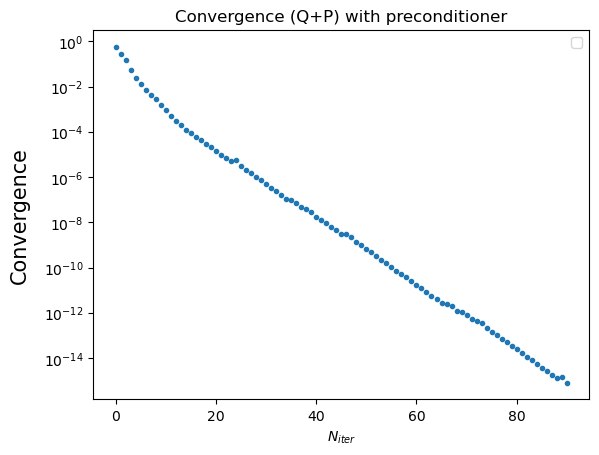

In [17]:
with open('/home/lkardum/moje-tekice/fmm-out_planck_precond_x0.pkl', 'rb') as f:
    y_planck_x0 = pickle.load(f)
plt.figure()
plt.plot(range(len(y_planck_x0['convergence'])), y_planck_x0['convergence'], '.')
plt.legend()
plt.title(r"Convergence (Q+P) with preconditioner")
plt.ylabel(r'Convergence', fontsize=15, labelpad=10)
plt.yscale('log')
plt.xlabel(r'$N_{iter}$')

Text(0.5, 0, '$N_{iter}$')

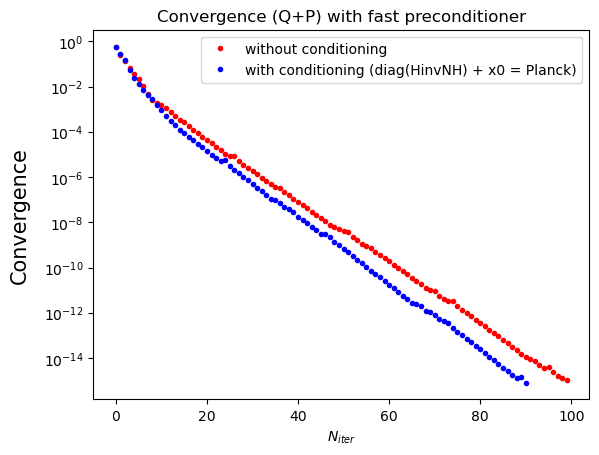

In [18]:
plt.figure()
plt.plot(range(len(x_planck['convergence'])), x_planck['convergence'], '.', label = 'without conditioning', color = 'red')
plt.plot(range(len(y_planck_x0['convergence'])), y_planck_x0['convergence'], '.', label = 'with conditioning (diag(HinvNH) + x0 = Planck)', color = 'blue')
plt.legend()
plt.title(r"Convergence (Q+P) with fast preconditioner")
plt.ylabel(r'Convergence', fontsize=15, labelpad=10)
plt.yscale('log')
plt.xlabel(r'$N_{iter}$')

In [3]:
parameters_path = '/home/lkardum/Downloads/params.yml'
with open(parameters_path, 'r') as tf:
    params_alexandre = yaml.safe_load(tf)

In [4]:
params_alexandre['QUBIC']['npointings'] = 10000
params_alexandre['SKY']['coverage_cut'] = 0.1
params_alexandre['PCG']['n_iter_pcg'] = 100

In [5]:
pip_alexandre = PipelineFrequencyMapMaking(comm = comm, file = '/home/lkardum/moje-tekice/fmm-out.pkl', parameters_dict= params_alexandre)

executing: self.detarray = '/home/lkardum/micromamba/envs/venv-localzadnji/lib/python3.10/site-packages/qubic/calfiles/CalQubic_DetArray_v4_FI.fits'
executing: self.hornarray = '/home/lkardum/micromamba/envs/venv-localzadnji/lib/python3.10/site-packages/qubic/calfiles/CalQubic_HornArray_FI.fits'
executing: self.optics = '/home/lkardum/micromamba/envs/venv-localzadnji/lib/python3.10/site-packages/qubic/calfiles/CalQubic_Optics_v3_FI_150.txt'
executing: self.primbeam = '/home/lkardum/micromamba/envs/venv-localzadnji/lib/python3.10/site-packages/qubic/calfiles/CalQubic_PrimBeam_v2.fits'
executing: self.synthbeam = '/home/lkardum/micromamba/envs/venv-localzadnji/lib/python3.10/site-packages/qubic/calfiles/CalQubic_Synthbeam_Analytical_220_FI.fits'
executing: self.detarray = '/home/lkardum/micromamba/envs/venv-localzadnji/lib/python3.10/site-packages/qubic/calfiles/CalQubic_DetArray_v4_FI.fits'
executing: self.hornarray = '/home/lkardum/micromamba/envs/venv-localzadnji/lib/python3.10/site-p

In [6]:
pip_alexandre.run()


=========== Map-Making ===========

 Iter     Tol      time
   1: 5.6634e-01 6.12693 [26.16774916  1.00815602  0.99690494 47.25086367  1.47889693  1.54099406]
   2: 2.4929e-01 5.85789 [17.45240438  0.96062535  0.99557805 29.41447065  1.48721662  1.62755851]
   3: 1.4077e-01 5.99771 [14.97660662  0.73859518  0.78443905 18.65705224  1.33680902  1.42534132]
   4: 6.6290e-02 6.10353 [13.5165805   0.59520315  0.60680579 12.27296729  1.12978371  1.16132299]
   5: 3.7003e-02 6.62301 [12.32968436  0.56714047  0.57789655  9.90556775  0.96452486  0.97659421]
   6: 2.0684e-02 6.03132 [11.84171546  0.59305996  0.60379122  9.1253346   0.86087788  0.87288744]
   7: 1.0391e-02 6.11852 [11.72908768  0.62924709  0.64001338  8.83231493  0.81006947  0.82789881]
   8: 4.3910e-03 6.22857 [11.71897931  0.66224818  0.67359926  8.71743186  0.79044781  0.81318842]
   9: 2.0714e-03 6.46291 [11.71612549  0.68692727  0.69816538  8.68472193  0.79321246  0.81957124]
  10: 1.1392e-03 6.34910 [11.72291589  0.7087773

In [17]:
import healpy as hp
import qubic

In [18]:
d = qubic.lib.qubicDict()
dictfilename = 'qubic/qubic/dicts/pipeline_demo.dict'
d.read_from_file(dictfilename)

center = qubic.lib.equ2gal(d['RA_center'], d['DEC_center'])

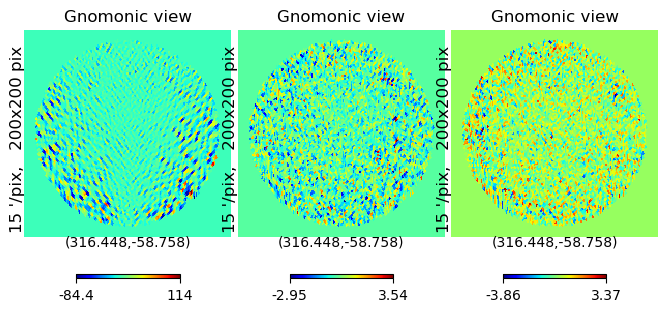

In [ ]:
for i in range(3):
    hp.gnomview(pip_alexandre.s_hat_noise[0,:,i] - pip_alexandre, sub=(1,3,i+1), rot=center, reso=15, cmap='jet')


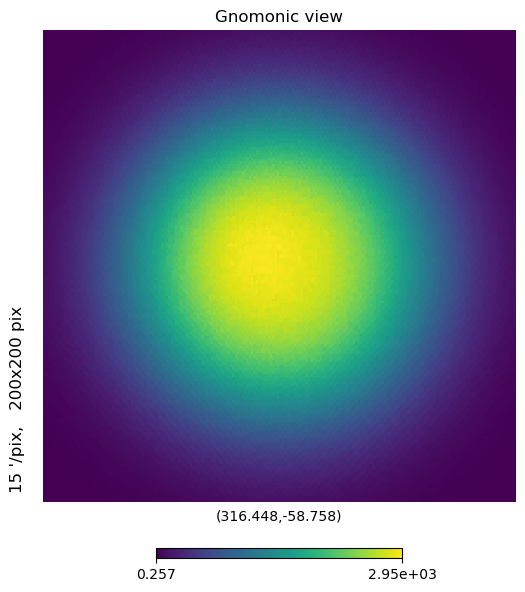

: 

In [ ]:
hp.gnomview(pip_alexandre.coverage[:], rot = center, reso=15)